In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.4 MB/s eta 0:00:00


In [7]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


**Using DEAP to get started**

Best Individual: [-928.1199524617815, -222.81774452717355, 287.92443091234406, 367.49581174697647, -257.62490749270995, -338.61517748599056, -636.4924768704466, 125.79007799618078, 258.704690224421, -470.0095782883747, -903.778082389104, 225.72627175258043, -458.10071462825834, 476.0637589896196, 347.2793347284211, 69.82936117036206, -41.97688000249215, 257.59028508438854, 627.3234047598663, 84.21011095731764, 543.7311583921946, 155.7841618989013, 298.54215961488734, -149.7601742483155, 365.8709197347323, 80.25378616217917, 549.8297388917814, 70.06553338202676, 245.008053564779, 250.124388945018, 52.85414820980992, 325.1522093798852, 745.4958987239974, 771.0879543811739, 13.775779830065105, 172.43129243841707, -751.7808677424491, 674.0536143150543, 20.772833595249338, 572.244057357298, 265.5499427497227, 242.05205257203033, 390.0661709205215, 239.37029464097944, 600.403624085984, 157.167526550191, 328.69692246013074, -600.096540759238, 141.67047282038448, 181.99272394317939, 2147.81736

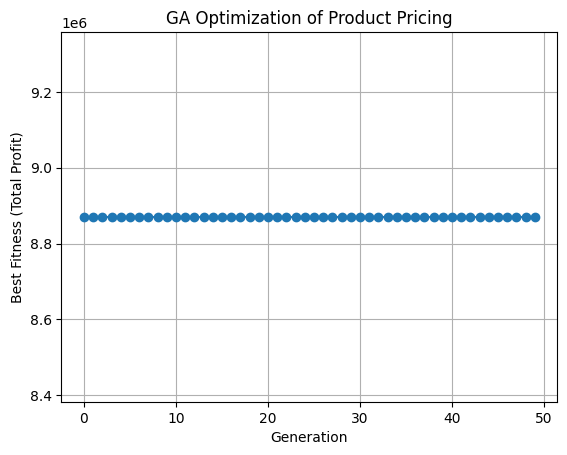

In [ ]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Define the objective function data
def calc_profit(product_price, order_quantity, benefit_per_order):
    return (benefit_per_order * order_quantity).sum()

def calc_revenue(product_price, order_quantity):
    return (product_price * order_quantity).sum()

# GA Setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # We are maximizing profit
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define bounds for the product price
PRICE_LOW, PRICE_HIGH = 10, 500

# Attribute generator: each individual will have random prices between PRICE_LOW and PRICE_HIGH
toolbox.register("attr_float", random.uniform, PRICE_LOW, PRICE_HIGH)

# Structure initializers: defining the structure of individuals
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(df['Product Price']))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function to evaluate individuals
def evaluate(individual):
    product_prices = np.array(individual)
    order_quantity = df['Order_Demand']
    benefit_per_order = df['Order Profit Per Order']

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return (total_profit,)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Genetic Algorithm Main Loop
def run_ga():
    random.seed(64)
    population = toolbox.population(n=100)

    # Number of generations
    NGEN = 50
    # Probability of crossover and mutation
    CXPB, MUTPB = 0.5, 0.2

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Track best fitness values over generations
    best_fitness_values = []

    # Begin the evolution
    for gen in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the next generation
        population[:] = offspring

        # Record the best fitness value in the current generation
        best_ind = tools.selBest(population, 1)[0]
        best_fitness_values.append(best_ind.fitness.values[0])

    # Gather all the fitnesses in one list and print the best individual
    fits = [ind.fitness.values[0] for ind in population]

    best_ind = tools.selBest(population, 1)[0]
    print(f"Best Individual: {best_ind}")
    print(f"Best Fitness (Total Profit): {best_ind.fitness.values[0]}")

    # Plot the best fitness values over generations
    plt.plot(range(NGEN), best_fitness_values, marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness (Total Profit)')
    plt.title('GA Optimization of Product Pricing')
    plt.grid(True)
    plt.show()

# Run the GA
run_ga()

**The PyGAD Code**

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best Individual: [116.7559376  317.97943129 220.57528172 ... 141.59220988 301.689244
 284.76080612]
Best Fitness (Total Profit): 8870218.389888603


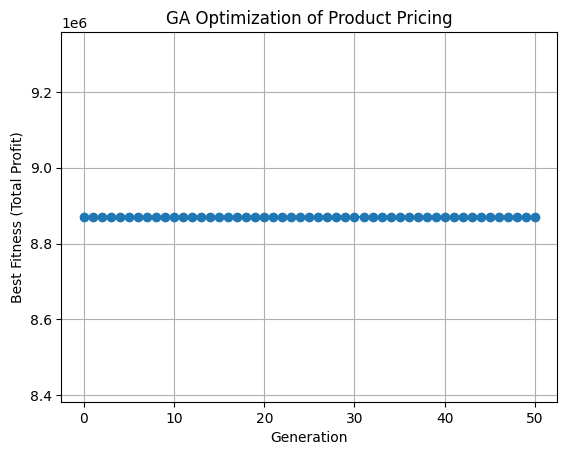

In [ ]:
import pandas as pd
import numpy as np
import pygad
import random
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Define the objective function data
def calc_profit(product_prices, order_quantity, benefit_per_order):
    return (benefit_per_order * order_quantity).sum()

# Fitness function to evaluate individuals
def fitness_function(ga_instance, solution, solution_idx):
    product_prices = np.array(solution)
    order_quantity = df['Order_Demand']
    benefit_per_order = df['Order Profit Per Order']

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# GA parameters
gene_space = {'low': 10, 'high': 500}  # Bounds for product prices

# Number of genes (one per product)
num_genes = len(df['Product Price'])

# Defining the GA instance
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=20,
    fitness_func=fitness_function,
    sol_per_pop=100,
    num_genes=num_genes,
    gene_space=gene_space,
    parent_selection_type="tournament",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20,
    keep_parents=2
)

# Run the GA
ga_instance.run()

# Extract the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best Individual: {solution}")
print(f"Best Fitness (Total Profit): {solution_fitness}")

# Plotting the fitness over generations
plt.plot(ga_instance.best_solutions_fitness, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Total Profit)')
plt.title('GA Optimization of Product Pricing')
plt.grid(True)
plt.show()

**The PyGAD GPU Code with PyTorch**

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best Individual: [125.84208884 293.97307803 293.16942188 ... 365.22689189 413.20873036
 187.0455644 ]
Best Fitness (Total Profit): 8870218.0
   Product Price  Optimized Price
0         327.75       125.842089
1         327.75       293.973078
2         327.75       293.169422
3         327.75       244.352876
4         327.75       405.287760


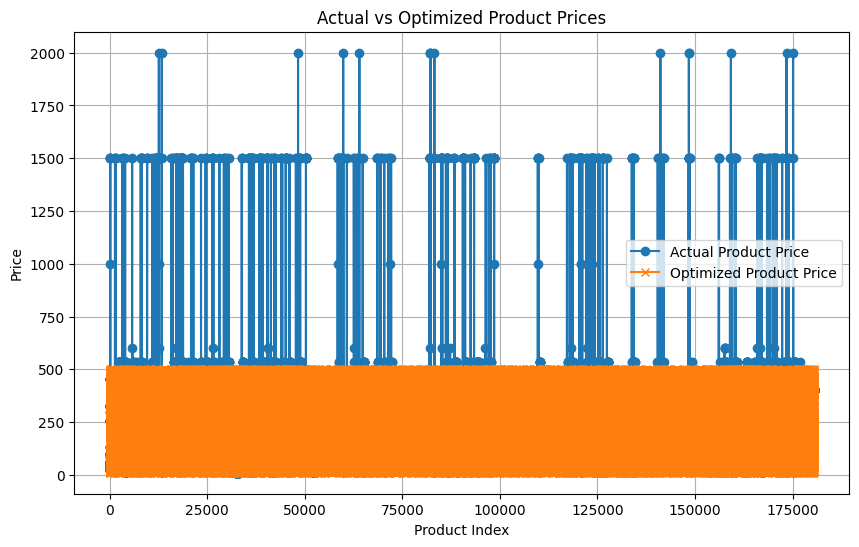

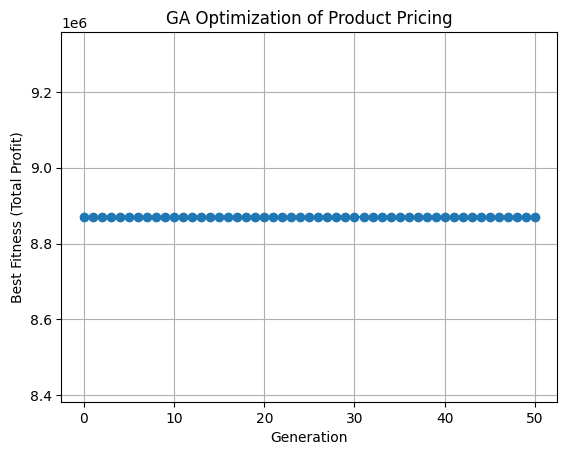

In [ ]:
import pandas as pd
import numpy as np
import pygad
import torch
import random
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function data using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum(benefit_per_order * order_quantity).item()
    return total_profit

# Fitness function to evaluate individuals
def fitness_function(ga_instance, solution, solution_idx):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# GA parameters
gene_space = {'low': 10, 'high': 500}  # Bounds for product prices

# Number of genes (one per product)
num_genes = len(df['Product Price'])

# Defining the GA instance
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=20,
    fitness_func=fitness_function,
    sol_per_pop=100,
    num_genes=num_genes,
    gene_space=gene_space,
    parent_selection_type="tournament",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20,
    keep_parents=2
)

# Run the GA
ga_instance.run()

# Extract the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best Individual: {solution}")
print(f"Best Fitness (Total Profit): {solution_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the fitness over generations
plt.plot(ga_instance.best_solutions_fitness, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Total Profit)')
plt.title('GA Optimization of Product Pricing')
plt.grid(True)
plt.show()

**The Improved PyGAD GPU Code**

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best Individual: [73.63248696 88.2123391  90.94704078 95.22964859 87.98648665 95.20275149
 78.15154109 79.59698666 92.83100122 97.5295752  77.68799998 88.31769037
 96.22117094 92.0336134  97.5582232  89.15057752 76.40310969 77.57881606
 86.78286965 99.30986767]
Best Fitness (Total Profit): 3452.21630859375
        Product Price  Optimized Price
80120      199.990005        73.632487
19670       50.000000        88.212339
114887      49.980000        90.947041
120110     299.980011        95.229649
56658       39.990002        87.986487


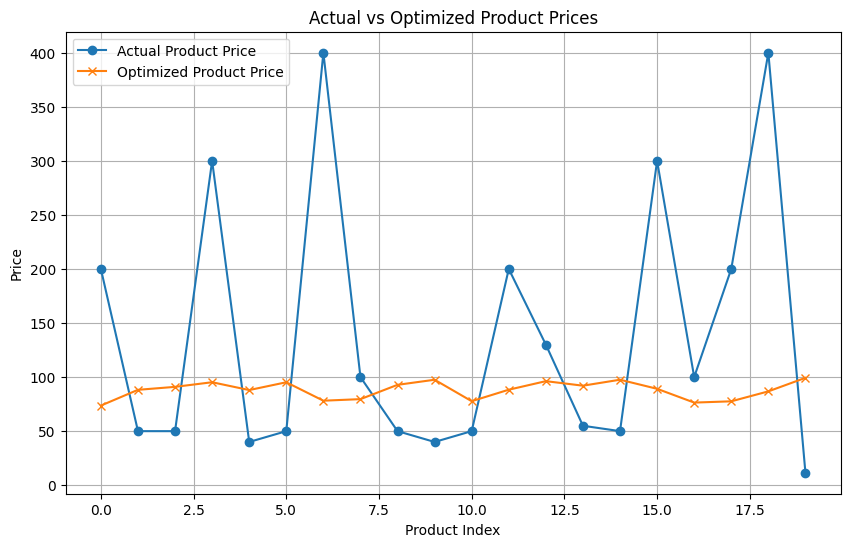

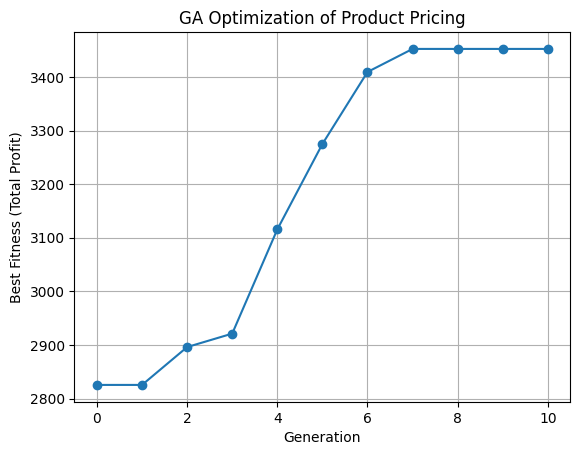

In [10]:
import pandas as pd
import numpy as np
import pygad
import torch
import random
import matplotlib.pyplot as plt

# 1. Load Dataset (simulating historical product price data)
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product_Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product_Category']]

# Limit dataset size for quick proof of concept
df = df.sample(n=20, random_state=42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define a realistic demand-price relationship
def demand_price_relationship(price):
    """
    Demand decreases exponentially as price increases to simulate price elasticity.
    """
    base_demand = 1000  # Base demand when price is very low
    elasticity = -0.05  # Price elasticity factor (negative to indicate inverse relationship)
    demand = base_demand * np.exp(elasticity * (price - 30))
    return max(demand, 0)  # Ensure demand is non-negative

# 3. Define the GA objective function to maximize profit using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum((product_prices - 20) * order_quantity).item()
    return total_profit

# Fitness function to evaluate individuals
def fitness_function(ga_instance, solution, solution_idx):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# 4. GA parameters
gene_space = {'low': 30, 'high': 100}  # Bounds for product prices

# Number of genes (one per product)
num_genes = len(df['Product Price'])

# Defining the GA instance
ga_instance = pygad.GA(
    num_generations=10,  # Reduced number of generations for faster execution
    num_parents_mating=5,  # Fewer parents for faster convergence
    fitness_func=fitness_function,
    sol_per_pop=20,  # Smaller population size for quicker results
    num_genes=num_genes,
    gene_space=gene_space,
    parent_selection_type="tournament",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10,  # Lower mutation percentage
    keep_parents=1
)

# 5. Run the GA
ga_instance.run()

# Extract the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best Individual: {solution}")
print(f"Best Fitness (Total Profit): {solution_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# 6. Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# 7. Plotting the fitness over generations
plt.plot(ga_instance.best_solutions_fitness, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Total Profit)')
plt.title('GA Optimization of Product Pricing')
plt.grid(True)
plt.show()

**Particle Swarm Optimzation **

In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=337241a3037ccd9ae82ea9785f185d1b62f7c73872e5b320195ac468667a72e6
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


Stopping search: maximum iterations reached --> 50
Best Individual: [ 79.73371313 126.69386625  48.81382324 ... 441.42338763  25.30084238
 288.64352159]
Best Fitness (Total Profit): 8870218.0
   Product Price  Optimized Price
0         327.75        79.733713
1         327.75       126.693866
2         327.75        48.813823
3         327.75       484.507880
4         327.75       368.474126


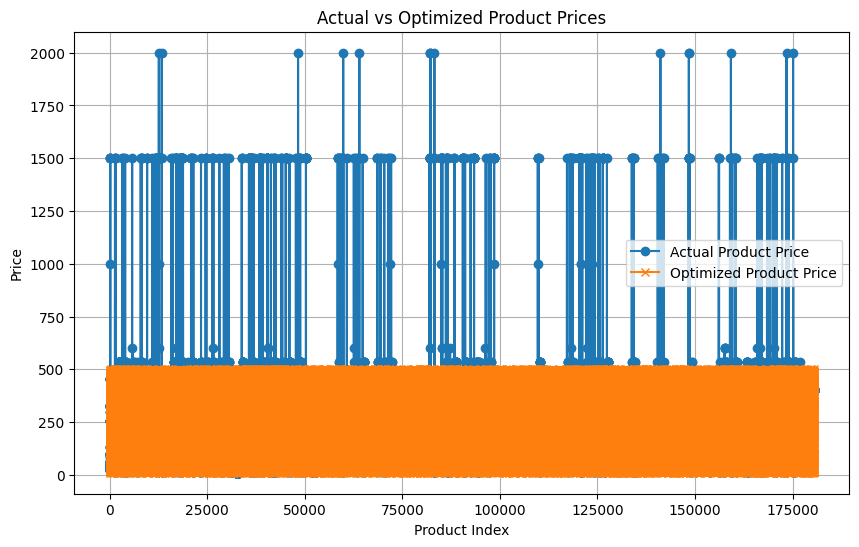

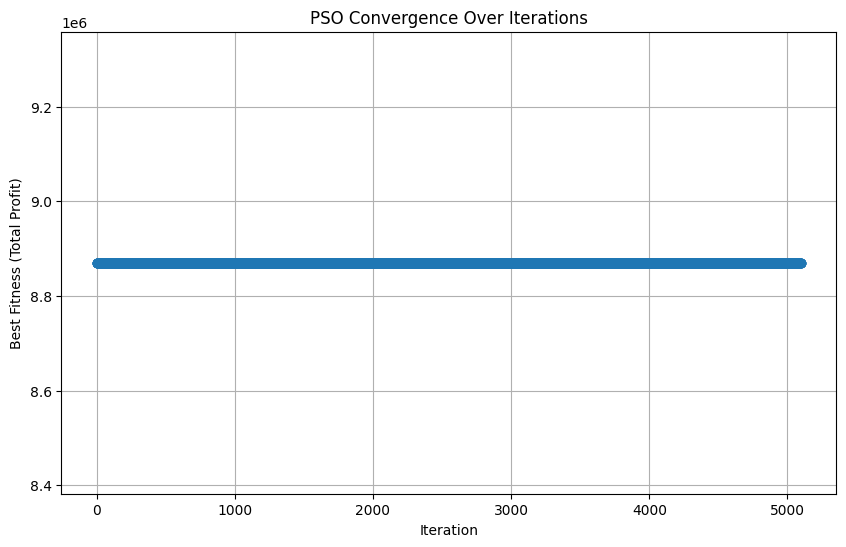

In [ ]:
!pip install pyswar
import pandas as pd
import numpy as np
import torch
import pyswarm
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function data using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum(benefit_per_order * order_quantity).item()
    return -total_profit  # Negative for minimization by PSO

# Objective function for PSO
def fitness_function(solution):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# PSO bounds
lb = [10] * len(df['Product Price'])  # Lower bound for product prices
ub = [500] * len(df['Product Price'])  # Upper bound for product prices

# Define a list to capture the best fitness value per iteration
fitness_history = []

# Custom PSO function to store fitness per iteration
def fitness_function_with_logging(solution):
    fitness = fitness_function(solution)
    fitness_history.append(-fitness)  # Append the positive value of profit
    return fitness

# Run PSO
best_solution, best_fitness = pyswarm.pso(fitness_function_with_logging, lb, ub, swarmsize=100, maxiter=50)

# Extract the best solution
print(f"Best Individual: {best_solution}")
print(f"Best Fitness (Total Profit): {-best_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# Plotting PSO convergence
plt.figure(figsize=(10, 6))
plt.plot(fitness_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (Total Profit)')
plt.title('PSO Convergence Over Iterations')
plt.grid(True)
plt.show()

**Particle Swarm Optimization (PSO)**

Stopping search: maximum iterations reached --> 50
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 50
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 50
Stopping search: maximum iterations reached --> 100
Best Parameters: {'swarmsize': 50, 'maxiter': 50}
Best Individual: [406.43702678 266.38281898 215.04774499 ... 328.96681219 257.34357029
 198.01694215]
Best Fitness (Total Profit): 8870218.0
   Product Price  Optimized Price
0         327.75       406.437027
1         327.75       266.382819
2         327.75       215.047745
3         327.75       371.637203
4         327.75       315.629723


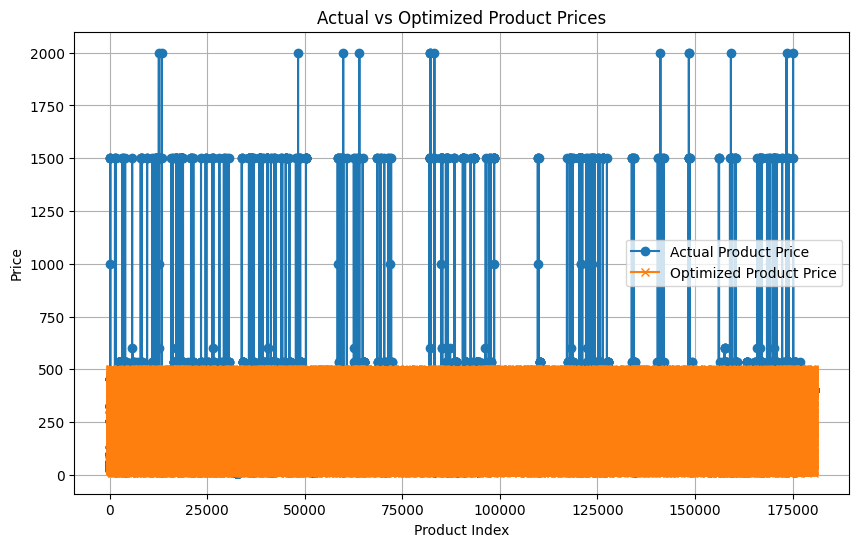

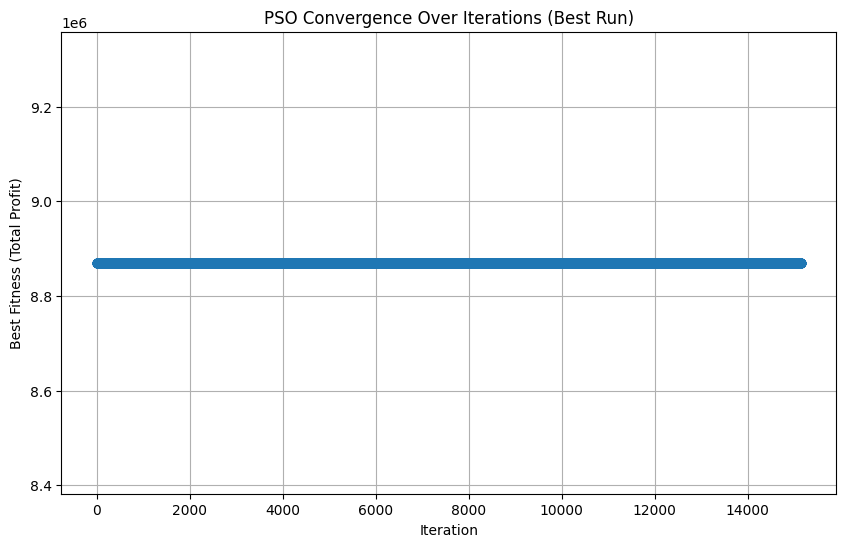

In [ ]:
import pandas as pd
import numpy as np
import torch
import pyswarm
import matplotlib.pyplot as plt
import itertools

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function data using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum(benefit_per_order * order_quantity).item()
    return -total_profit  # Negative for minimization by PSO

# Objective function for PSO
def fitness_function(solution):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# PSO bounds
lb = [10] * len(df['Product Price'])  # Lower bound for product prices
ub = [500] * len(df['Product Price'])  # Upper bound for product prices

# Define a list to capture the best fitness value per iteration
fitness_history = []

# Custom PSO function to store fitness per iteration
def fitness_function_with_logging(solution):
    fitness = fitness_function(solution)
    fitness_history.append(-fitness)  # Append the positive value of profit
    return fitness

# Parameter grids for automated tuning
swarm_sizes = [50, 100, 150]  # Different swarm sizes to test
max_iters = [50, 100]  # Different iteration counts to test

# Store the best overall solution and its parameters
best_overall_solution = None
best_overall_fitness = float('inf')
best_parameters = None

# Perform Grid Search for PSO parameter tuning
for swarmsize, maxiter in itertools.product(swarm_sizes, max_iters):
    # Clear fitness history for the new run
    fitness_history.clear()

    # Run PSO with current parameter set
    best_solution, best_fitness = pyswarm.pso(
        fitness_function_with_logging,
        lb,
        ub,
        swarmsize=swarmsize,
        maxiter=maxiter
    )

    # Check if this is the best fitness so far
    if best_fitness < best_overall_fitness:
        best_overall_fitness = best_fitness
        best_overall_solution = best_solution
        best_parameters = {'swarmsize': swarmsize, 'maxiter': maxiter}

# Print the best parameters and solution
print(f"Best Parameters: {best_parameters}")
print(f"Best Individual: {best_overall_solution}")
print(f"Best Fitness (Total Profit): {-best_overall_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_overall_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# Plotting PSO convergence for the best run
plt.figure(figsize=(10, 6))
plt.plot(fitness_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (Total Profit)')
plt.title('PSO Convergence Over Iterations (Best Run)')
plt.grid(True)
plt.show()

In [4]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=286aedffbd5b6d19743e48af750de81f8c0c9f73aa5bfe9c4f4f109f2baaf457
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


Stopping search: maximum iterations reached --> 50
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 50
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 50
Stopping search: maximum iterations reached --> 100
Best Parameters: {'swarmsize': 150, 'maxiter': 100}
Best Individual: [83.59063392 30.         30.72918051 ... 93.06315458 97.54234591
 98.49364503]
Best Fitness (Total Profit): 17508588.0
   Product Price  Optimized Price
0         327.75        83.590634
1         327.75        30.000000
2         327.75        30.729181
3         327.75        79.670020
4         327.75        30.000530


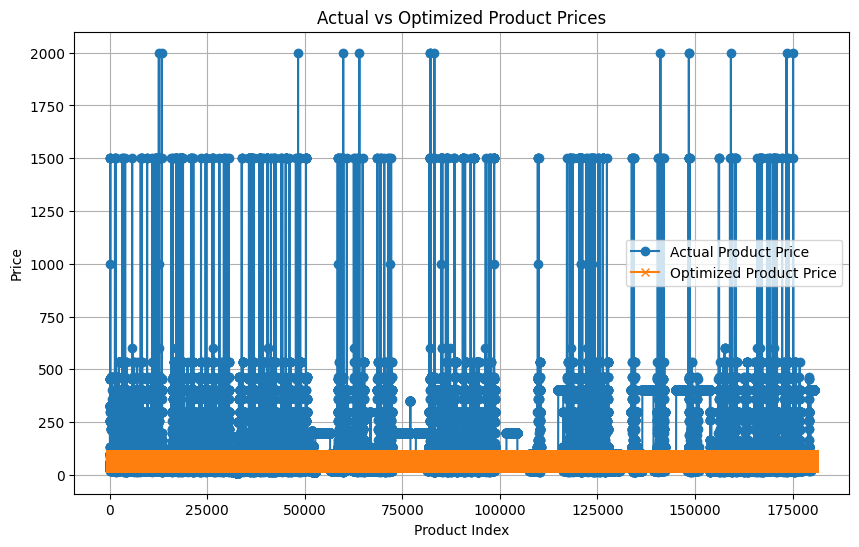

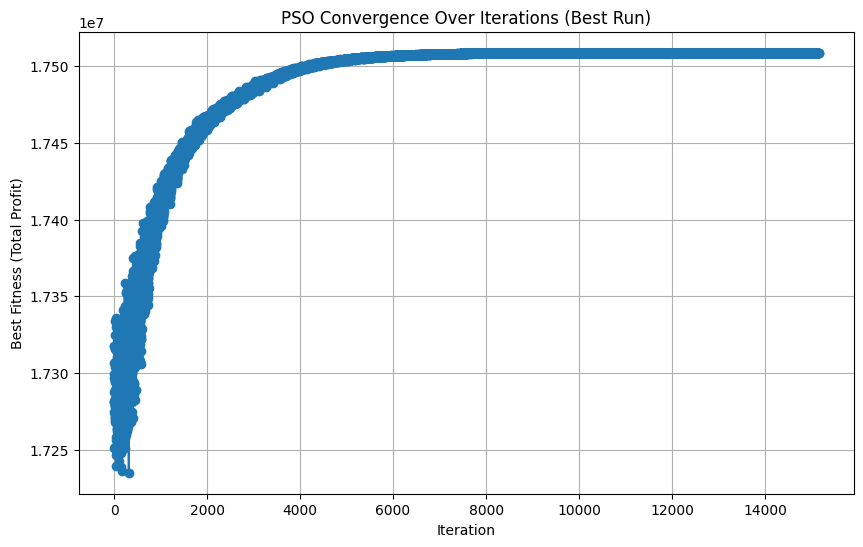

In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import itertools
from pyswarm import pso

# 1. Load Dataset (simulating historical product price data)
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product_Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product_Category']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define a realistic demand-price relationship
def demand_price_relationship(price):
    """
    Demand decreases exponentially as price increases to simulate price elasticity.
    """
    base_demand = 1000  # Base demand when price is very low
    elasticity = -0.05  # Price elasticity factor (negative to indicate inverse relationship)
    demand = base_demand * np.exp(elasticity * (price - 30))
    return max(demand, 0)  # Ensure demand is non-negative

# 3. Define the PSO objective function to maximize profit using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum((product_prices - 20) * order_quantity).item()
    return -total_profit  # Negative for minimization by PSO

# Objective function for PSO
def fitness_function(solution):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# 4. PSO bounds
lb = [30] * len(df['Product Price'])  # Lower bound for product prices
ub = [100] * len(df['Product Price'])  # Upper bound for product prices

# Define a list to capture the best fitness value per iteration
fitness_history = []

# Custom PSO function to store fitness per iteration
def fitness_function_with_logging(solution):
    fitness = fitness_function(solution)
    fitness_history.append(-fitness)  # Append the positive value of profit
    return fitness

# 5. Parameter grids for automated tuning
swarm_sizes = [50, 100, 150]  # Different swarm sizes to test
max_iters = [50, 100]  # Different iteration counts to test

# Store the best overall solution and its parameters
best_overall_solution = None
best_overall_fitness = float('inf')
best_parameters = None

# Perform Grid Search for PSO parameter tuning
for swarmsize, maxiter in itertools.product(swarm_sizes, max_iters):
    # Clear fitness history for the new run
    fitness_history.clear()

    # Run PSO with current parameter set
    best_solution, best_fitness = pso(
        fitness_function_with_logging,
        lb,
        ub,
        swarmsize=swarmsize,
        maxiter=maxiter
    )

    # Check if this is the best fitness so far
    if best_fitness < best_overall_fitness:
        best_overall_fitness = best_fitness
        best_overall_solution = best_solution
        best_parameters = {'swarmsize': swarmsize, 'maxiter': maxiter}

# Print the best parameters and solution
print(f"Best Parameters: {best_parameters}")
print(f"Best Individual: {best_overall_solution}")
print(f"Best Fitness (Total Profit): {-best_overall_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_overall_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# 6. Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# 7. Plotting PSO convergence for the best run
plt.figure(figsize=(10, 6))
plt.plot(fitness_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (Total Profit)')
plt.title('PSO Convergence Over Iterations (Best Run)')
plt.grid(True)
plt.show()

In [17]:
!pip install scikit-opt

Best Individual: [78.36520949 88.6447202  77.68879478 68.19020839 75.82344023 86.53071732
 53.66019428 85.31179888 99.79271722 75.06616882 94.62113196 98.4444354
 95.57116415 80.56599135 96.78605983 79.00884026 62.80646503 46.08556291
 62.57849985 68.8884963 ]
Best Fitness (Total Profit): 3095.815760322875
        Product Price  Optimized Price
80120      199.990005        78.365209
19670       50.000000        88.644720
114887      49.980000        77.688795
120110     299.980011        68.190208
56658       39.990002        75.823440


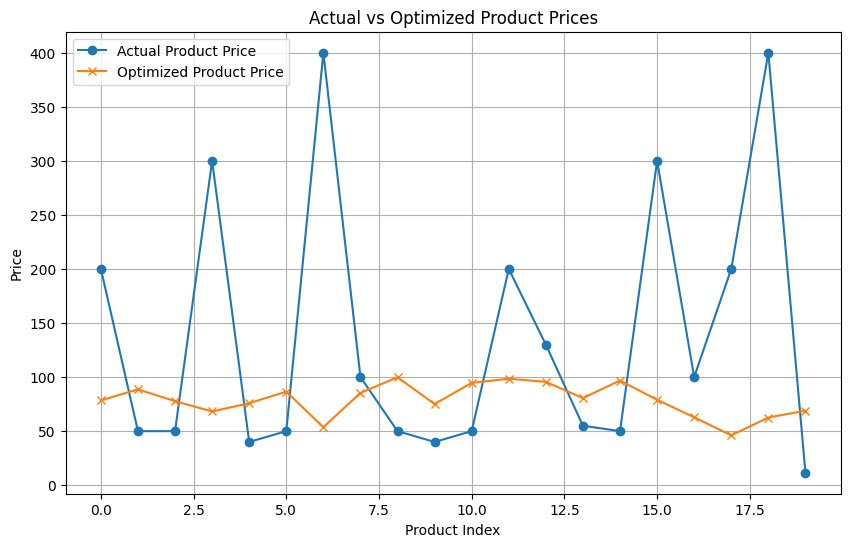

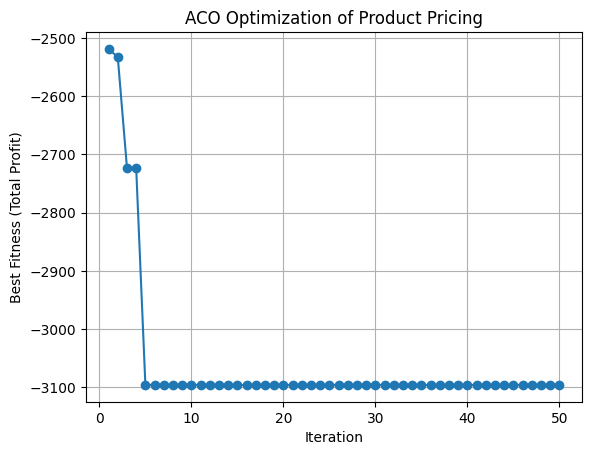

In [23]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sko.ACA import ACA_TSP

# 1. Load Dataset (simulating historical product price data)
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product_Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product_Category']]

# Limit dataset size for quick proof of concept
df = df.sample(n=20, random_state=42)

# 2. Define the objective function to maximize profit
def calc_profit(product_prices, order_quantity):
    product_prices = np.array(product_prices)
    order_quantity = np.array(order_quantity)
    cost = 20  # Fixed cost per product

    total_profit = np.sum((product_prices - cost) * order_quantity)
    return -total_profit  # Negative to minimize in ACO

# Fitness function to evaluate solutions
def fitness_function(solution):
    product_prices = solution
    order_quantity = df['Order_Demand'].values

    total_profit = calc_profit(product_prices, order_quantity)
    return total_profit

# Define Ant Colony Optimization instance (modified approach)
class CustomAntColony:
    def __init__(self, func, n_dim, num_ants=10, num_iterations=50, alpha=1, beta=2, evaporation_rate=0.5):
        self.func = func
        self.n_dim = n_dim
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone = np.ones((n_dim,))
        self.best_solution = None
        self.best_cost = float('inf')
        self.best_y_history = []

    def run(self):
        for iteration in range(self.num_iterations):
            solutions = []
            costs = []
            for ant in range(self.num_ants):
                solution = np.random.uniform(30, 100, self.n_dim)  # Random solution within bounds
                cost = self.func(solution)
                solutions.append(solution)
                costs.append(cost)
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_solution = solution
            # Update pheromones
            avg_cost = np.mean(costs)
            self.pheromone = (1 - self.evaporation_rate) * self.pheromone + self.evaporation_rate * (1 / (avg_cost + 1e-10))
            self.best_y_history.append(self.best_cost)
        return self.best_solution, self.best_cost

# Run the Custom Ant Colony Optimization
n_dim = len(df['Product Price'])  # Number of products to optimize
colony = CustomAntColony(func=fitness_function, n_dim=n_dim, num_ants=10, num_iterations=50)
best_solution, best_profit = colony.run()

# Convert profit back to positive
best_profit = -best_profit
print(f"Best Individual: {best_solution}")
print(f"Best Fitness (Total Profit): {best_profit}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# 6. Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# 7. Plotting the fitness over iterations (Convergence)
plt.plot(range(1, len(colony.best_y_history) + 1), colony.best_y_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (Total Profit)')
plt.title('ACO Optimization of Product Pricing')
plt.grid(True)
plt.show()